In [1]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [2]:
from fenics import *
import numpy as np
from mshr import *
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import imageio

In [3]:
def sol(V, alpha, f, h, g):

  def boundary(x, on_boundary):
    return on_boundary

  bc = DirichletBC(V, h, boundary)
  u = TrialFunction(V)
  v = TestFunction(V)
  a = (dot(grad(u), grad(v)) + alpha * u * v) * dx
  L = f * v * dx + g * v * ds

  u = Function(V)
  solve(a == L, u, bc)

  return u

In [4]:
def error(u_exact, u, mesh):
  error_L2 = errornorm(u_exact, u, 'L2')

  vertex_values_u_exact = u_exact.compute_vertex_values(mesh)
  vertex_values_u = u.compute_vertex_values(mesh)

  error_max = np.max(np.abs(vertex_values_u_exact - vertex_values_u))

  return error_L2, error_max

In [5]:
r = Expression("sqrt(x[0] * x[0] + x[1] * x[1])", degree = 2)
phi = Expression("atan2(x[1], x[0])", degree = 2)

R = 1

domain = Circle(Point(0, 0), R)
mesh = generate_mesh(domain, 32)
V = FunctionSpace(mesh, 'P', 2)

In [6]:
def mesh_plot(mesh, u1, u2, title = "", vmin = None, vmax = None, image_name = "", close = True):
  n = mesh.num_vertices()
  d = mesh.geometry().dim()
  mesh_coordinates = mesh.coordinates().reshape((n, d))
  triangles = np.asarray([cell.entities(0) for cell in cells(mesh)])
  triangulation = tri.Triangulation(mesh_coordinates[:, 0], mesh_coordinates[:, 1], triangles)

  fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (5, 10))

  plt.subplot(211)
  zfaces= np.asarray([u1(cell.midpoint()) for cell in cells(mesh)])
  plt.tripcolor(triangulation, facecolors = zfaces, cmap='coolwarm', vmin = vmin, vmax = vmax)
  plt.colorbar()
  plt.title(title + ". Numerical solution.")
  plt.plot()

  plt.subplot(212)
  zfaces= np.asarray([u2(cell.midpoint()) for cell in cells(mesh)])
  plt.tripcolor(triangulation, facecolors = zfaces, cmap='coolwarm', vmin = vmin, vmax = vmax)
  plt.colorbar()
  plt.title(title + ". Exact solution.")
  plt.plot()

  plt.savefig(f"{image_name}.png")

  if close:
    plt.close()

# Пункт 1


## Пример 1-1

$$u = r^2 \cdot \sin(\phi), \alpha = 1, R = 1$$

L2-error = 0.07094290362545679
Max-error = 0.07746310756922278


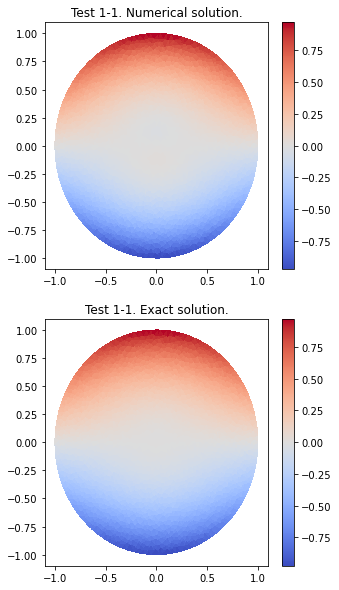

In [7]:
u_exact = Expression("r * r * sin(phi)", r = r, phi = phi, degree = 2)
alpha = Constant(1)
f = Expression("(r * r - 4) * sin(phi)", r = r, phi = phi, degree = 2)
h = Expression("sin(phi)", phi = phi, degree = 2)
g = Expression("2 * sin(phi)", phi = phi, degree = 2)

u = sol(V, alpha, f, h, g)

error_L2, error_max = error(u_exact, u, mesh)
print('L2-error =', error_L2)
print('Max-error =', error_max)

mesh_plot(mesh, u, u_exact, "Test 1-1", image_name = "Test 1-1", close = False)

## Пример 1-2

$$u = r^3 \cdot \cos(\phi) + 1, \alpha = 3, R = 1$$

L2-error = 0.03706848595825077
Max-error = 0.03932786714856373


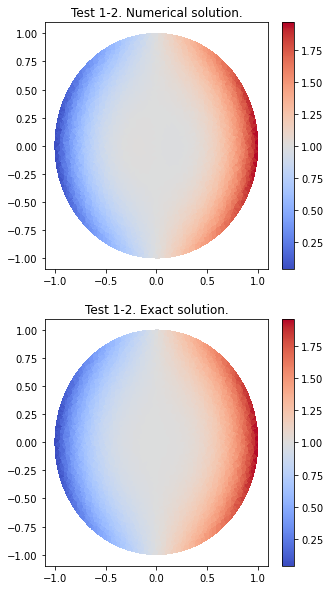

In [8]:
u_exact = Expression("r * r * r * cos(phi) + 1", r = r, phi = phi, degree = 2)
alpha = Constant(3)
f = Expression("3 * r * (r * r - 3) * cos(phi) + 3", r = r, phi = phi, degree = 2)
h = Expression("cos(phi) + 1", phi = phi, degree = 2)
g = Expression("3 * cos(phi)", phi = phi, degree = 2)

u = sol(V, alpha, f, h, g)

error_L2, error_max = error(u_exact, u, mesh)
print('L2-error =', error_L2)
print('Max-error =', error_max)

mesh_plot(mesh, u, u_exact, "Test 1-2", image_name = "Test 1-2", close = False)

## Пример 1-3

$$u = r^2 \cdot \cos ^ 2(\phi), \alpha = 1, R = 1$$

L2-error = 0.0819363363928596
Max-error = 0.08851377942692559


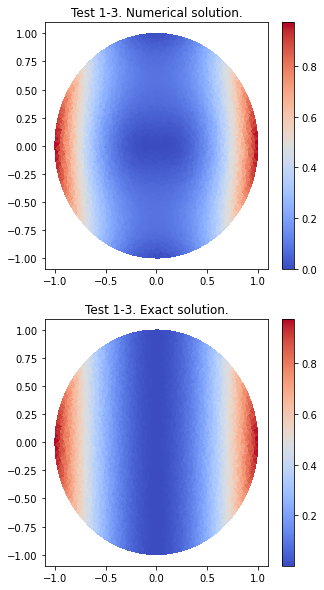

In [9]:
u_exact = Expression("r * r * cos(phi) * cos(phi)", r = r, phi = phi, degree = 2)
alpha = Constant(1)
f = Expression("(r * r - 4) * cos(phi) * cos(phi)", r = r, phi = phi, degree = 2)
h = Expression("cos(phi) * cos(phi)", phi = phi, degree = 2)
g = Expression("2 * cos(phi) * cos(phi)", phi = phi, degree = 2)

u = sol(V, alpha, f, h, g)

error_L2, error_max = error(u_exact, u, mesh)
print('L2-error =', error_L2)
print('Max-error =', error_max)

mesh_plot(mesh, u, u_exact, "Test 1-3", image_name = "Test 1-3", close = False)

# Пункт 2

In [10]:
def max_min(u_num_t, u_exact_t):
  max_v = []
  min_v = []
  for i in range(len(u_num_t)):
    max_v.append(u_num_t[i].vector().max())
    min_v.append(u_num_t[i].vector().min())
    max_v.append(u_exact_t[i].vector().max())
    min_v.append(u_exact_t[i].vector().min())
  return max(max_v), min(min_v)

In [11]:
def save_gif(file_name):
  with imageio.get_writer(f"{file_name}.gif", mode = 'i', duration = 0.3) as writer:
      for i in range(num_iters):
          image = imageio.imread(f"{i}.png")
          writer.append_data(image)

In [12]:
def error_plot(error_L2_t, error_max_t, name):
  plt.title(f"Errors. {name}.")
  plt.plot(error_L2_t, label='L2-error')
  plt.plot(error_max_t, label='Max-error')
  plt.xlabel("iteration")
  plt.ylabel("value")
  plt.legend()
  plt.savefig(f"errors {name}.png")

In [13]:
T = 2.0
num_iters = 10
dt = T / num_iters

In [14]:
def heat_eq(u_exact_f, f_f, h_f, g_f, alpha_val, name):
  t = 0
  u_exact = Expression(u_exact_f, t = t, r = r, phi = phi, degree = 2)
  alpha = Constant(alpha_val)
  f = Expression(f_f, t = t, r = r, phi = phi, degree = 2)
  h = Expression(h_f, t = t, phi = phi, degree = 2)
  g = Expression(g_f, t = t, phi = phi, degree = 2)
  u_n = interpolate(h, V)

  u_num_t = [u_n.copy()]
  u_exact_t = [interpolate(u_exact, V)]
  error_L2_t = []
  error_max_t = []
  for i in range(num_iters):
    t += dt
    u_exact.t = t
    f.t = t
    h.t = t
    g.t = t

    u = sol(V, alpha, f, h, g)

    u_n.assign(u)

    u_num_t.append(u_n.copy())
    u_exact_t.append(interpolate(u_exact, V))

    error_L2, error_max = error(u_exact, u, mesh)
    error_L2_t.append(error_L2)
    error_max_t.append(error_max)

  vmax, vmin = max_min(u_num_t, u_exact_t)
  for i in range(num_iters):
    mesh_plot(mesh, u_exact_t[i], u_num_t[i], name, vmin, vmax, image_name = f"{i}")
  
  save_gif(name)
  error_plot(error_L2_t, error_max_t, name)

## Пример 2-1

$$u = t^2 \cdot r^2 \cdot \sin (\phi), \alpha = 1, R = 1$$

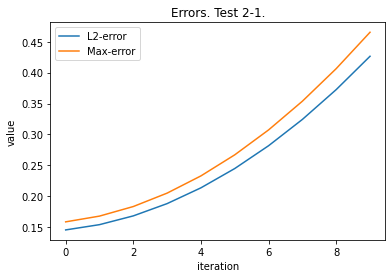

In [15]:
heat_eq("t * t * r * r * sin(phi)", "- 2 * (2 * t * t + 1) * sin(phi) + t * t * r * r * sin(phi)", "t * t * sin(phi)", "2 * t * t * sin(phi)", 1, "Test 2-1")

## Пример 2-2

$$u = t^2 \cdot r^3 \cdot \cos (\phi) + 1, \alpha = 3, R = 1$$

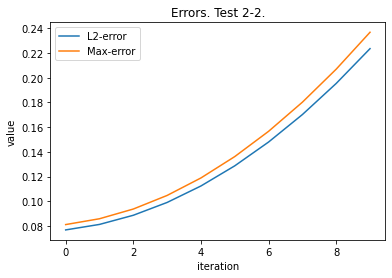

In [16]:
heat_eq("t * t * r * r * r * cos(phi) + 1", "-r * (9 * t * t + 2) * cos(phi) + 3 * t * t * r * r * r * cos(phi) + 3", "t * t * cos(phi) + 1", "3 * t * t * cos(phi)", 3, "Test 2-2")

## Пример 2-3

$$u = t^2 \cdot r^2 \cdot \cos ^ 2 (\phi), \alpha = 1, R = 1$$

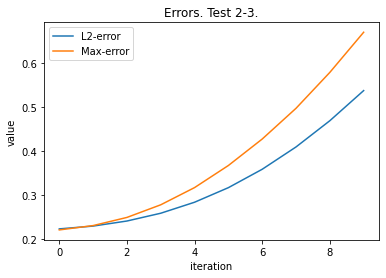

In [17]:
heat_eq("t * t * r * r * cos(phi) * cos(phi)", "-2 * (2 * t * t + 1) * cos(phi) * cos(phi)", "t * t * cos(phi) * cos(phi)", "2 * t * t * cos(phi) * cos(phi)", 1, "Test 2-3")